In [3]:
Needs["Screws`", "./Screws.m"];
Needs["RobotLinks`", "./RobotLinks.m"];

In [5]:
(* base pose of link i frame in the snake head frame (all joint angles = 0) *)
gsi0[i_] := TwistExp[{0, l(i - 1), 0, 0, 0, 0}, 1];

(* twist coordinates for joint i *)
ξ[i_] := Piecewise[{{{0, 0, -l(i - 1/2), 1, 0, 0}, EvenQ[i]},
              {{l(i - 1/2), 0, 0, 0, 0, 1}, OddQ[i]}}];

n = 4; 
ids = Range[n];
gsi0s = Map[gsi0, ids];
ξs = Map[ξ, ids];

(* create vector of angles which are all functions of t *)
θs = Through[Array[Indexed[θ, #] &, n][t]];

(* product of exponentials FK for pose of link i frame in the snake head frame *)
gs[i_] := Dot @@ Append[MapThread[TwistExp, {ξs[[;; i-1]], θs[[;; i-1]]}], gsi0s[[i]]] // Simplify;

2
 l (Sin[θ [t]] (θ )'[t]  - Cos[θ [t]] (θ )''[t])
         1       1              1       1
{-----------------------------------------------, 
                        2
 
      1                         2
>   -(-) (l (Cos[θ [t]] (θ )'[t]  + Sin[θ [t]] (θ )''[t])), 0}
      2           1       1              1       1
                      2
 l Sin[θ [t]] (θ )'[t]
        1       1          1                        2
{----------------------, -(-) (l Cos[θ [t]] (θ )'[t] ), 0}
           2               2          1       1
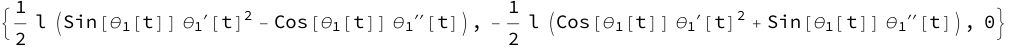
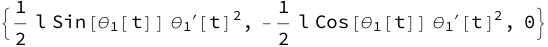

In [23]:
(* differentiate position twice wrt time to get acceleration *)
p[i_] := gs[i][[;; 3, -1]];
v[i_] := D[p[i], t];
a[i_] := D[p[i], {t, 2}];

(* set all joint accelerations to zero since we are assuming constant joint velocity *)
acv[i_] := a[i] /. Thread[D[θs, {t, 2}] -> 0];

a[2] // Simplify
acv[2] // Simplify

0


0

(θ )'[t]
  1
            -(θ )'[t]
0              1        0

(θ )'[t]
  1         0           0


0           0           0
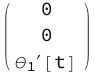
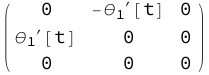

In [29]:
(* differentiate rotation matrix to get angular velocity *)
R[i_] := gs[i][[1 ;; 3, 1 ;; 3]];
ωhat[i_] := D[R[i], t].Transpose[R[i]];
ω[i_] := UnSkew[ωhat[i]];

ω[2] // Simplify // MatrixForm
ωhat[2] // Simplify // MatrixForm


2
                 l Sin[θ [t]] (θ )'[t]
                        1       1          1                        2
Transpose[Ck] . {----------------------, -(-) (l Cos[θ [t]] (θ )'[t] ), 0} + 
                           2               2          1       1
 
>   Transpose[Transpose[Ck] . {{Cos[θ [t]], -Sin[θ [t]], 0}, 
                                     1            1
 
>       {Sin[θ [t]], Cos[θ [t]], 0}, {0, 0, 1}}] . Transpose[Rk] . {ak, ak, -9.81 + ak}
              1           1
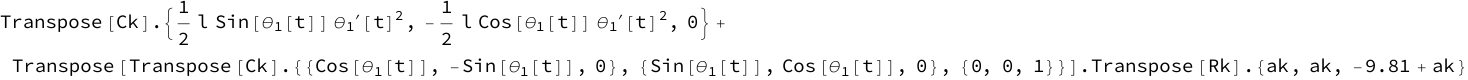

In [103]:
(* quaternion to rotation matrix *)
qtoR[{x_, y_, z_, w_}] := {{w^2 + x^2 - y^2 - z^2, 2(x*y - z*w), 2(x*z + y*w)},
                       {2(x*y + z*w), w^2 - x^2 + y^2 - z^2, 2(y*z - x*w)},
                       {2(x*z - y*w), 2(y*z + x*w), w^2 - x^2 - y^2 + z^2}};

$Assumptions = {ak ∈ Vector[3, Reals],
                qk ∈ Vector[4, Reals],
                ωk ∈ Vector[3, Reals],
                Ck ∈ Matrix[{3, 3}, Reals],
                Rk ∈ Matrix[{3, 3}, Reals]};

(* ak = {ax, ay, az};
qk = {qx, qy, qz, qw};
ωk = {ωx, ωy, ωz};
xk = Join[ak, qk, ωk];
Rk = qtoR[qk]; *)

xk = Join[ak, qk, ωk];
(* Ck // TensorDimensions *)

(* rotation matrix from virtual chassis frame to snake head frame *)
(* Ck = {{C11, C12, C13}, {C21, C22, C23}, {C31, C32, C33}}; *)
(* Ck = IdentityMatrix[3]; *)

g = {0, 0, -9.81};

W[i_] := Transpose[Ck].R[i];

(* predicted acceleration measurement at link i *)
αhat[i_] := Transpose[W[i]].Transpose[Rk].(g + ak) + Transpose[Ck].acv[i];

(* predicted angular velocity measurement at link i *)
γhat[i_] := Transpose[W[i]].ωk + Transpose[Ck].ω[i];

αhat[2] // TensorReduce // Simplify // MatrixForm
γhat[2] // Simplify;


In [120]:

(* zhat = Join[Array[αhat, n], Array[γhat, n]] // Flatten // Simplify; *)

(* measurement jacobian *)
(* h11 = Dt[zhat[[1]], {xk}] // TensorReduce // Simplify *)
(* H = D[zhat, {xk}] // Simplify // MatrixForm; *)

In [104]:
(* Scratch Work *)
d = 4;
$Assumptions = {Element[x, Vectors[d, Reals]],
                Element[Q, Matrices[{d, d}, Reals, Symmetric[{1, 2}]]],
                Element[M, Matrices[{d, d}]]};

V = Transpose[x].Q.x // Simplify
D[V, {x}] // Simplify
Transpose[V] // Simplify
Transpose[Q].x + Q.x // TensorReduce // Simplify



(* angles = {0, π/2, 0, 0};
gs[3] // Simplify // MatrixForm;
gs[3] /. Thread[θs -> angles] // Simplify // MatrixForm; *)
(* p[3] // Simplify *)
(* v[2] // Simplify *)

(* gs1 = gsi0s[[1]] // MatrixForm
gs2 = TwistExp[ξ[1], θs[[1]]].gsi0s[[2]] // Simplify // MatrixForm
gs3 = TwistExp[ξ[1], θs[[1]]].TwistExp[ξ[2], θs[[2]]].gsi0s[[3]] // Simplify // MatrixForm *)

Transpose[x] . Q . x
Transpose[x] . Q . 1 + Transpose'[x] . Q . x
Transpose[Transpose[x] . Q . x]
2 Q . x